**Import all necessary modules**

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import io
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
print(tf.__version__)

2.5.0


**Upload CSV file that will be used as dataset**

In [ ]:
student_por = files.upload()

Saving student-por.csv to student-por (1).csv


**Convert table into Pandas dataframe**

In [ ]:
df_student_por = pd.read_csv(io.BytesIO(student_por['student-por.csv']))

# **Project Overview**
In this project i will attempt to build a model that can predict student's final grade scores (G3) based on attributes available on the data. Based on my assessment, the attributes that may affect student's grade are as follows:
1.   Parent's education ('Medu' & 'Fedu')
2.   Weekly committed studytime ('studytime')
3.   History of failures ('failures')
4.   Extra Educational support ('schoolsup', 'famsup' & 'paid')
5.   Rate of Alcohol consumption ('Dalc' & 'Walc')

However, aside from those potential external factor, there is also information of past grades ('G1' & 'G2') that may better represent their inner potential and may have greater effect on their last grade. So i would also like to compare the predictions between a model that don't take past grades into account with a model that does.






# **Case 1: External Factors Only**

Slice the dataframe to only contain required attributes

In [ ]:
encoded = df_student_por[['Medu','Fedu','studytime','failures','schoolsup','famsup','paid','higher','Dalc','Walc','G3']]
encoded

,Medu,Fedu,studytime,failures,schoolsup,famsup,paid,higher,Dalc,Walc,G3
0,4,4,2,0,yes,no,no,yes,1,1,11
1,1,1,2,0,no,yes,no,yes,1,1,11
2,1,1,2,0,yes,no,no,yes,2,3,12
3,4,2,3,0,no,yes,no,yes,1,1,14
4,3,3,2,0,no,yes,no,yes,1,2,13
...,...,...,...,...,...,...,...,...,...,...,...
644,2,3,3,1,no,no,no,yes,1,2,10
645,3,1,2,0,no,yes,no,yes,1,1,16
646,1,1,2,0,no,no,no,yes,1,1,9
647,3,1,1,0,no,no,no,yes,3,4,10


Since some attributes are of string types ('yes'/'no'), convert them into binary so that its correlation with final grade can be mapped

In [ ]:
encoded = encoded.replace('yes',1)
encoded = encoded.replace('no',0)
encoded

,Medu,Fedu,studytime,failures,schoolsup,famsup,paid,higher,Dalc,Walc,G3
0,4,4,2,0,1,0,0,1,1,1,11
1,1,1,2,0,0,1,0,1,1,1,11
2,1,1,2,0,1,0,0,1,2,3,12
3,4,2,3,0,0,1,0,1,1,1,14
4,3,3,2,0,0,1,0,1,1,2,13
...,...,...,...,...,...,...,...,...,...,...,...
644,2,3,3,1,0,0,0,1,1,2,10
645,3,1,2,0,0,1,0,1,1,1,16
646,1,1,2,0,0,0,0,1,1,1,9
647,3,1,1,0,0,0,0,1,3,4,10


Check correlation between selected attributes with final grade

In [ ]:
corrmatrix_por = encoded.corr()
y_corr = corrmatrix_por.loc['G3']
y_corr

Medu         0.240151
Fedu         0.211800
studytime    0.249789
failures    -0.393316
schoolsup   -0.066405
famsup       0.059206
paid        -0.054898
higher       0.332172
Dalc        -0.204719
Walc        -0.176619
G3           1.000000
Name: G3, dtype: float64

As seen above, the correlations between each attribute to final grade are relatively high with the exception 'schoolsup', 'famsup', and 'paid'. However i decided to keep them in the model.

Next step, as some attributes are categorical, is to do a one-hot-encoding on them to better map the relation between each category with final grade score.

In [ ]:
encoded = pd.get_dummies(encoded, columns=['Medu','Fedu','studytime','failures','schoolsup','famsup','paid','higher','Dalc','Walc'])
encoded

,G3,Medu_0,Medu_1,Medu_2,Medu_3,Medu_4,Fedu_0,Fedu_1,Fedu_2,Fedu_3,Fedu_4,studytime_1,studytime_2,studytime_3,studytime_4,failures_0,failures_1,failures_2,failures_3,schoolsup_0,schoolsup_1,famsup_0,famsup_1,paid_0,paid_1,higher_0,higher_1,Dalc_1,Dalc_2,Dalc_3,Dalc_4,Dalc_5,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5
0,11,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0
1,11,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0
2,12,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
3,14,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0
4,13,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,10,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0
645,16,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0
646,9,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0
647,10,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0


Partition the dataset into training dataset (to train the model) and test dataset (to test model's prediction). I used ratios of 80%-20%.

In [ ]:
encoded_train = encoded.sample(frac=0.8, random_state=0)
encoded_test = encoded.drop(encoded_train.index)
x_train = encoded_train.drop(columns=['G3'])
y_train = encoded_train['G3']
x_test = encoded_train.drop(columns=['G3'])
y_test = encoded_train['G3']

Normalize the training features (x_train)

In [ ]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(x_train))
print(normalizer.mean.numpy())

[0.012 0.208 0.285 0.231 0.264 0.012 0.27  0.322 0.21  0.187 0.314 0.489
 0.141 0.056 0.84  0.11  0.029 0.021 0.902 0.098 0.387 0.613 0.94  0.06
 0.106 0.894 0.697 0.175 0.067 0.029 0.031 0.391 0.231 0.173 0.123 0.081]


Define the neural network model

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

Compile the model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
# dnn_model.summary()

Train the model

In [ ]:
history = dnn_model.fit(
    x_train, y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

Define a function for plotting historical progress of the model's training. This will show decrease in losses throughout the training iterations

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 5])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

Plot the training history

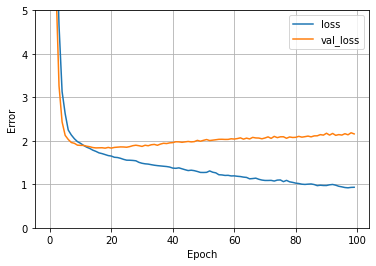

In [ ]:
plot_loss(history)

Check the average of loss from the model's training

In [ ]:
test_results = {}

test_results['dnn_model'] = dnn_model.evaluate(x_test, y_test, verbose=0)
pd.DataFrame(test_results, index=['mean loss']).T

,mean loss
dnn_model,1.149876


Make predictions using testing features (x_test)

In [ ]:
test_predictions = dnn_model.predict(x_test).flatten()

Plot prediction results against the true testing values (y_test)

DNN_Model mean loss = 1.149876356124878


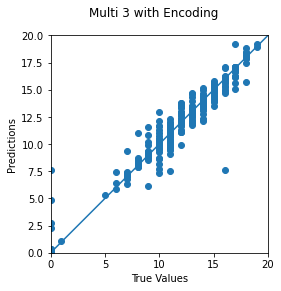

In [ ]:
print('DNN_Model mean loss = ' + str(test_results['dnn_model']))
a = plt.axes(aspect='equal')
plt.suptitle('External Factors Only')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# **Case 2: External & Internal Factors**

Simply repeat the process while including past grades attribute

In [ ]:
encoded_2 = df_student_por[['Medu','Fedu','studytime','failures','schoolsup','famsup','paid','higher','Dalc','Walc','G1','G2','G3']]

encoded_2 = encoded_2.replace('yes',1)
encoded_2 = encoded_2.replace('no',0)

corrmatrix_por = encoded_2.corr()
y_corr = corrmatrix_por.loc['G3']
y_corr

Medu         0.240151
Fedu         0.211800
studytime    0.249789
failures    -0.393316
schoolsup   -0.066405
famsup       0.059206
paid        -0.054898
higher       0.332172
Dalc        -0.204719
Walc        -0.176619
G1           0.826387
G2           0.918548
G3           1.000000
Name: G3, dtype: float64

As seen above, past grades have much greater relevance to final grade

In [ ]:
encoded_2_train = encoded_2.sample(frac=0.8, random_state=0)
encoded_2_test = encoded_2.drop(encoded_2_train.index)
x_train_2 = encoded_2_train.drop(columns=['G3'])
y_train_2 = encoded_2_train['G3']
x_test_2 = encoded_2_train.drop(columns=['G3'])
y_test_2 = encoded_2_train['G3']

normalizer_2 = preprocessing.Normalization()
normalizer_2.adapt(np.array(x_train_2))

dnn_model = build_and_compile_model(normalizer_2)
history_2 = dnn_model.fit(
    x_train_2, y_train_2,
    validation_split=0.2,
    verbose=0, epochs=100)

test_results['dnn_model_2'] = dnn_model.evaluate(x_test_2, y_test_2, verbose=0)
pd.DataFrame(test_results, index=['mean loss']).T

,mean loss
dnn_model,1.149876
dnn_model_2,0.601206


The test result shows that case 2 has much better average error

DNN_Model mean loss = 0.6012062430381775


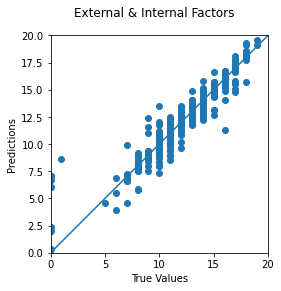

In [ ]:
test_predictions_2 = dnn_model.predict(x_test_2).flatten()

print('DNN_Model mean loss = ' + str(test_results['dnn_model_2']))
a = plt.axes(aspect='equal')
plt.suptitle('External & Internal Factors')
plt.scatter(y_test_2, test_predictions_2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)